# from Weekly Project 2: Robots

In [40]:
import sys
import cv2
import numpy as np
import pathlib

sys.path.append("..")

import matplotlib.pyplot as plt
from collections import defaultdict
from tracking.kalman import MultiObjectTracker, iou_xyxy


In [41]:
#load frames
SEQ_PATH = "../data_rect/seq_01"  


In [42]:
image_dir = pathlib.Path(SEQ_PATH) / "image_02" / "data"
frame_paths = sorted(image_dir.glob("*.png"))
right_image_dir = pathlib.Path(SEQ_PATH) / "image_03" / "data"
frame_paths_right = sorted(right_image_dir.glob("*.png"))
if len(frame_paths) < 2:
    raise RuntimeError(f"Need at least two frames in {image_dir} to compute optical flow.")
if len(frame_paths) != len(frame_paths_right):
    raise RuntimeError("Left/right image folders need same number of frames")

print(f"Loaded {len(frame_paths)} stereo frames from {image_dir} and {right_image_dir}")

def load_frame(idx):
    frame = cv2.imread(str(frame_paths[idx]))
    if frame is None:
        raise RuntimeError(f"Unable to read image {frame_paths[idx]}")
    return frame

def load_frame_right(idx):
    frame = cv2.imread(str(frame_paths_right[idx]))
    if frame is None:
        raise RuntimeError(f"Unable to read image {frame_paths_right[idx]}")
    return frame

frame = load_frame(0)


Loaded 145 stereo frames from ../data_rect/seq_01/image_02/data and ../data_rect/seq_01/image_03/data


In [43]:
ROAD_RATIO = 0.45


def non_max_suppression(boxes, iou_threshold=0.4):
    if not boxes:
        return []
    boxes_np = np.array(boxes, dtype=np.float32)
    x1 = boxes_np[:, 0]
    y1 = boxes_np[:, 1]
    x2 = boxes_np[:, 2]
    y2 = boxes_np[:, 3]
    areas = (x2 - x1) * (y2 - y1)
    idxs = np.argsort(y2)
    keep = []

    while len(idxs) > 0:
        last = idxs[-1]
        keep.append(last)
        idxs = idxs[:-1]
        if len(idxs) == 0:
            break
        xx1 = np.maximum(x1[last], x1[idxs])
        yy1 = np.maximum(y1[last], y1[idxs])
        xx2 = np.minimum(x2[last], x2[idxs])
        yy2 = np.minimum(y2[last], y2[idxs])

        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        overlap = w * h
        iou = overlap / (areas[last] + areas[idxs] - overlap + 1e-6)
        idxs = idxs[np.where(iou <= iou_threshold)[0]]

    return [list(map(int, boxes_np[i])) for i in keep]


def compute_sparse_motion_boxes(gray_prev, gray_curr, kernel_sparse, road_start, top_k=80, min_area=800, nms_thresh=0.35):
    boxes = []
    feat1 = cv2.goodFeaturesToTrack(gray_prev, maxCorners=300, qualityLevel=0.2, minDistance=5)
    if feat1 is None:
        return boxes

    feat2, status, _ = cv2.calcOpticalFlowPyrLK(gray_prev, gray_curr, feat1, None)
    if feat2 is None or status is None:
        return boxes

    status = status.reshape(-1).astype(bool)
    if not np.any(status):
        return boxes

    feat2_valid = feat2[status]
    feat1_valid = feat1[status]
    displacements = np.linalg.norm(feat2_valid - feat1_valid, axis=2).flatten()
    top_k = min(top_k, len(displacements))
    if top_k == 0:
        return boxes

    sparse_mask = np.zeros_like(gray_curr, dtype=np.uint8)
    top_idx = np.argpartition(displacements, -top_k)[-top_k:]
    for idx in top_idx:
        x, y = feat2_valid[idx][0]
        if y < road_start:
            continue
        cv2.circle(sparse_mask, (int(x), int(y)), 10, 255, -1)

    if not np.any(sparse_mask):
        return boxes

    sparse_mask = cv2.morphologyEx(sparse_mask, cv2.MORPH_CLOSE, kernel_sparse, iterations=1)
    sparse_mask = cv2.dilate(sparse_mask, kernel_sparse, iterations=1)
    contours_info = cv2.findContours(sparse_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours_info[0] if len(contours_info) == 2 else contours_info[1]

    for cnt in contours:
        if cv2.contourArea(cnt) < min_area:
            continue
        x, y, w_box, h_box = cv2.boundingRect(cnt)
        x1 = max(x, 0)
        y1 = max(y, road_start)
        x2 = min(x + w_box, gray_curr.shape[1] - 1)
        y2 = min(y + h_box, gray_curr.shape[0] - 1)
        if x2 <= x1 or y2 <= y1:
            continue
        boxes.append([int(x1), int(y1), int(x2), int(y2)])

    return non_max_suppression(boxes, iou_threshold=nms_thresh)


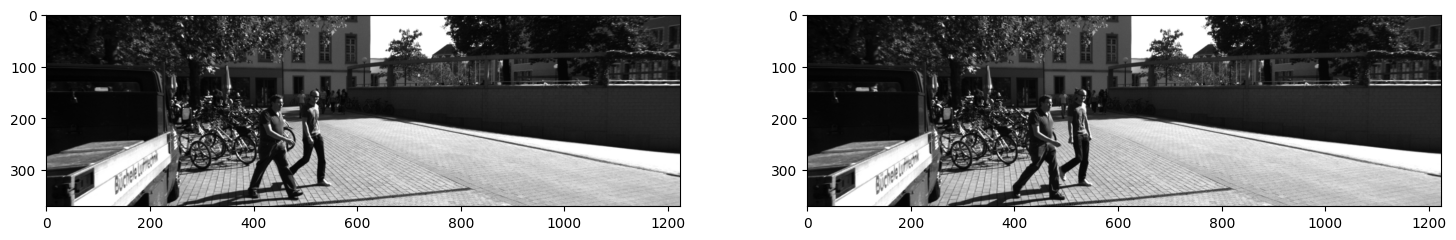

In [44]:
frame1 = load_frame(0)
frame2 = load_frame(1)

frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)

gray1 = cv2.cvtColor(frame1, cv2.COLOR_RGB2GRAY)
gray2 = cv2.cvtColor(frame2, cv2.COLOR_RGB2GRAY)

plt.figure(figsize = (18,18))
plt.subplot(1,2,1)
plt.imshow(gray1, cmap = 'gray')
plt.subplot(1,2,2)
plt.imshow(gray2, cmap = 'gray')


In [45]:
feat1 = cv2.goodFeaturesToTrack(gray1, maxCorners=100, qualityLevel=0.3, minDistance=7)
feat2, status, error = cv2.calcOpticalFlowPyrLK(gray1, gray2, feat1, None)


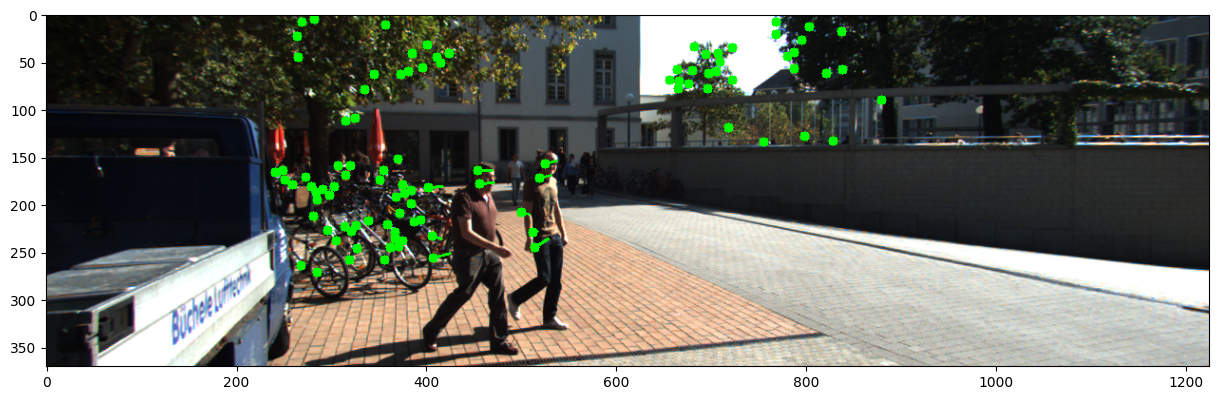

In [46]:
for i in range(len(feat1)):
    f10=int(feat1[i][0][0])
    f11=int(feat1[i][0][1])
    f20=int(feat2[i][0][0])
    f21=int(feat2[i][0][1])
    cv2.line(frame2, (f10,f11), (f20, f21), (0, 255, 0), 2)
    cv2.circle(frame2, (f10, f11), 5, (0, 255, 0), -1)

plt.figure(figsize=(15,15))
plt.imshow(frame2)

## Sparse optical flow

In [47]:
for idx in range(0, len(frame_paths) - 1, 2):
    frame1 = cv2.cvtColor(load_frame(idx), cv2.COLOR_BGR2RGB)
    frame2 = cv2.cvtColor(load_frame(idx + 1), cv2.COLOR_BGR2RGB)

    gray1 = cv2.cvtColor(frame1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_RGB2GRAY)

    feat1 = cv2.goodFeaturesToTrack(gray1, maxCorners=100, qualityLevel=0.3, minDistance=7)
    feat2, status, error = cv2.calcOpticalFlowPyrLK(gray1, gray2, feat1, None)

    for i in range(len(feat1)):
        if status[i] and np.linalg.norm(feat2[i] - feat1[i]) > 2:  # Only show features that moved
            f10 = int(feat1[i][0][0])
            f11 = int(feat1[i][0][1])
            f20 = int(feat2[i][0][0])
            f21 = int(feat2[i][0][1])
            cv2.line(frame2, (f10, f11), (f20, f21), (0, 255, 0), 2)
            cv2.circle(frame2, (f10, f11), 5, (0, 255, 0), -1)

    cv2.imshow('Tracked Moving Keypoints', cv2.cvtColor(frame2, cv2.COLOR_RGB2BGR))
    if cv2.waitKey(20) & 0xFF == 27:
        break  # Press ESC to exit

cv2.destroyAllWindows()


In [52]:
cv2.destroyAllWindows()


## Dense Optical Flow

In [48]:
for idx in range(0, len(frame_paths) - 1, 2):
    frame1 = cv2.cvtColor(load_frame(idx), cv2.COLOR_BGR2RGB)
    frame2 = cv2.cvtColor(load_frame(idx + 1), cv2.COLOR_BGR2RGB)

    gray1 = cv2.cvtColor(frame1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_RGB2GRAY)

    flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None, 0.5, 3, 15, 3, 5, 1.5, 0)
    mag, ang = cv2.cartToPolar(flow[:,:,0], flow[:,:,1])

    step = 16  # sample every 16 pixels
    h, w = mag.shape
    img_flow = frame2.copy()

    for y in range(0, h, step):
        for x in range(0, w, step):
            fx, fy = flow[y, x]
            if np.sqrt(fx**2 + fy**2) > 2:  # Only show vectors with significant movement
                cv2.arrowedLine(img_flow, (x, y), (int(x + fx), int(y + fy)), (255, 0, 0), 1, tipLength=0.4)

    cv2.imshow('Tracked Moving Keypoints (Dense Optical Flow)', cv2.cvtColor(img_flow, cv2.COLOR_RGB2BGR))
    if cv2.waitKey(30) & 0xFF == 27:  # Press ESC to exit
        break

cv2.destroyAllWindows()


## Bounding boxes on strongest motion


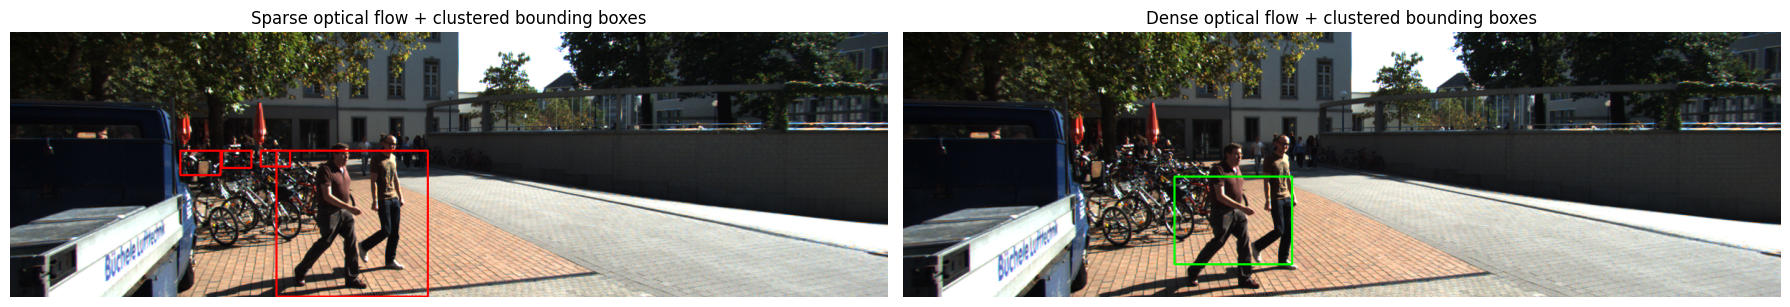

In [49]:
frame1 = load_frame(0)
frame2 = load_frame(1)

frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)

gray1 = cv2.cvtColor(frame1, cv2.COLOR_RGB2GRAY)
gray2 = cv2.cvtColor(frame2, cv2.COLOR_RGB2GRAY)

kernel_sparse = np.ones((21, 21), np.uint8)
kernel_dense = np.ones((25, 25), np.uint8)
road_start = int(frame2.shape[0] * ROAD_RATIO)

sparse_boxes = compute_sparse_motion_boxes(gray1, gray2, kernel_sparse, road_start)

# --- Dense optical flow (Farneback) ---
flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None, 0.5, 3, 15, 3, 5, 1.5, 0)
mag, _ = cv2.cartToPolar(flow[:, :, 0], flow[:, :, 1])
threshold = np.percentile(mag, 99)
if threshold == 0:
    threshold = np.percentile(mag, 95)
motion_mask = (mag >= threshold).astype(np.uint8) * 255
motion_mask[:road_start, :] = 0  # remove tree/sky responses
motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_CLOSE, kernel_dense, iterations=1)
motion_mask = cv2.dilate(motion_mask, kernel_dense, iterations=1)
contours_info = cv2.findContours(motion_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours_info[0] if len(contours_info) == 2 else contours_info[1]
dense_boxes = []
for cnt in contours:
    if cv2.contourArea(cnt) < 1200:
        continue
    x, y, w_box, h_box = cv2.boundingRect(cnt)
    dense_boxes.append((x, y, x + w_box, y + h_box))

frame_sparse_vis = frame2.copy()
frame_dense_vis = frame2.copy()
for x1, y1, x2, y2 in sparse_boxes:
    cv2.rectangle(frame_sparse_vis, (x1, y1), (x2, y2), (255, 0, 0), 2)
for x1, y1, x2, y2 in dense_boxes:
    cv2.rectangle(frame_dense_vis, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.title('Sparse optical flow + clustered bounding boxes')
plt.imshow(frame_sparse_vis)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Dense optical flow + clustered bounding boxes')
plt.imshow(frame_dense_vis)
plt.axis('off')
plt.tight_layout()


In [50]:
for idx in range(0, len(frame_paths) - 1):
    frame1_rgb = cv2.cvtColor(load_frame(idx), cv2.COLOR_BGR2RGB)
    frame2_rgb = cv2.cvtColor(load_frame(idx + 1), cv2.COLOR_BGR2RGB)

    gray1 = cv2.cvtColor(frame1_rgb, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(frame2_rgb, cv2.COLOR_RGB2GRAY)

    sparse_vis = frame2_rgb.copy()
    dense_vis = frame2_rgb.copy()

    kernel_sparse = np.ones((21, 21), np.uint8)
    kernel_dense = np.ones((25, 25), np.uint8)
    road_start = int(frame2_rgb.shape[0] * ROAD_RATIO)

    sparse_boxes = compute_sparse_motion_boxes(gray1, gray2, kernel_sparse, road_start)
    for x1, y1, x2, y2 in sparse_boxes:
        cv2.rectangle(sparse_vis, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # Dense optical flow magnitudes converted to regions
    flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None, 0.5, 3, 15, 3, 5, 1.5, 0)
    mag, _ = cv2.cartToPolar(flow[:, :, 0], flow[:, :, 1])
    threshold = np.percentile(mag, 99)
    if threshold == 0:
        threshold = np.percentile(mag, 95)
    motion_mask = (mag >= threshold).astype(np.uint8) * 255
    motion_mask[:road_start, :] = 0
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_CLOSE, kernel_dense, iterations=1)
    motion_mask = cv2.dilate(motion_mask, kernel_dense, iterations=1)
    contours_info = cv2.findContours(motion_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours_info[0] if len(contours_info) == 2 else contours_info[1]
    for cnt in contours:
        if cv2.contourArea(cnt) < 1200:
            continue
        x, y, w_box, h_box = cv2.boundingRect(cnt)
        cv2.rectangle(dense_vis, (x, y), (x + w_box, y + h_box), (0, 255, 0), 2)

    cv2.imshow('Sparse motion boxes', cv2.cvtColor(sparse_vis, cv2.COLOR_RGB2BGR))
    cv2.imshow('Dense motion boxes', cv2.cvtColor(dense_vis, cv2.COLOR_RGB2BGR))
    if cv2.waitKey(30) & 0xFF == 27:
        break

cv2.destroyAllWindows()


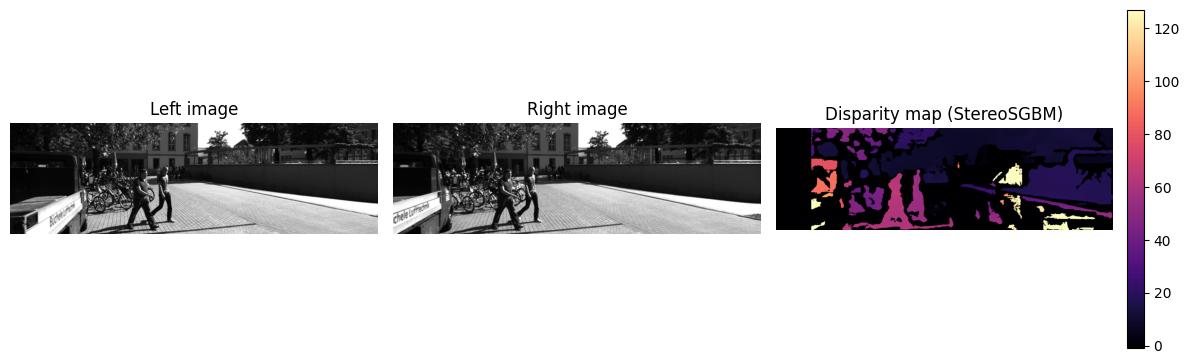

In [51]:
stereo_left_dir = pathlib.Path(SEQ_PATH) / "image_02" / "data"
stereo_right_dir = pathlib.Path(SEQ_PATH) / "image_03" / "data"
left_paths = sorted(stereo_left_dir.glob("*.png"))
right_paths = sorted(stereo_right_dir.glob("*.png"))
if len(left_paths) == 0 or len(left_paths) != len(right_paths):
    raise RuntimeError("Stereo folders must contain the same non-empty number of frames")

left = cv2.imread(str(left_paths[0]), cv2.IMREAD_GRAYSCALE)
right = cv2.imread(str(right_paths[0]), cv2.IMREAD_GRAYSCALE)
if left is None or right is None:
    raise RuntimeError("Failed to load stereo pair")

# Stereo block matcher tuned for KITTI
min_disp = 0
num_disp = 128  # must be divisible by 16
block_size = 15
stereo = cv2.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=block_size,
    P1=8 * 3 * block_size ** 2,
    P2=32 * 3 * block_size ** 2,
    disp12MaxDiff=1,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32,
)

disp = stereo.compute(left, right).astype(np.float32) / 16.0
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.title('Left image')
plt.imshow(left, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Right image')
plt.imshow(right, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Disparity map (StereoSGBM)')
plt.imshow(disp, cmap='magma')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')
plt.tight_layout()


## Kalman tracking of dense-motion detections


In [52]:
tracker = MultiObjectTracker(max_age=5, min_hits=2, iou_threshold=0.3)
kernel_sparse = np.ones((21, 21), np.uint8)
stereo_matcher = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=128,
    blockSize=15,
    P1=8 * 3 * 15 ** 2,
    P2=32 * 3 * 15 ** 2,
    disp12MaxDiff=1,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32,
)
baseline = 0.54  # KITTI stereo baseline in meters
focal_length = 721.0  # approx focal length in pixels
track_paths = defaultdict(list)
track_depths = {}

for idx in range(0, len(frame_paths) - 1):
    frame_prev = cv2.cvtColor(load_frame(idx), cv2.COLOR_BGR2RGB)
    frame_curr = cv2.cvtColor(load_frame(idx + 1), cv2.COLOR_BGR2RGB)
    right_curr = cv2.cvtColor(load_frame_right(idx + 1), cv2.COLOR_BGR2GRAY)

    gray_prev = cv2.cvtColor(frame_prev, cv2.COLOR_RGB2GRAY)
    gray_curr = cv2.cvtColor(frame_curr, cv2.COLOR_RGB2GRAY)

    road_start = int(frame_curr.shape[0] * ROAD_RATIO)
    sparse_boxes = compute_sparse_motion_boxes(gray_prev, gray_curr, kernel_sparse, road_start)

    disp = stereo_matcher.compute(gray_curr, right_curr).astype(np.float32) / 16.0
    detections = []
    detection_depths = []
    for x1, y1, x2, y2 in sparse_boxes:
        disp_roi = disp[y1:y2, x1:x2]
        valid = disp_roi > 1.0
        if valid.size == 0 or not np.any(valid):
            continue
        median_disp = float(np.median(disp_roi[valid]))
        depth = (focal_length * baseline) / max(median_disp, 1e-3)
        detections.append([x1, y1, x2, y2])
        detection_depths.append(depth)

    tracks = tracker.update(detections)

    # match detections to tracks for depth attribution
    for track in tracks:
        bbox = track['bbox']
        best_depth = track_depths.get(track['id'])
        best_iou = 0.0
        for det, depth in zip(detections, detection_depths):
            iou = iou_xyxy(bbox, det)
            if iou > best_iou:
                best_iou = iou
                best_depth = depth
        if best_depth is not None:
            track_depths[track['id']] = best_depth

    vis = frame_curr.copy()
    for track in tracks:
        x1, y1, x2, y2 = map(int, track['bbox'])
        cx = int((x1 + x2) / 2)
        cy = int((y1 + y2) / 2)
        track_paths[track['id']].append((cx, cy))
        if len(track_paths[track['id']]) > 80:
            track_paths[track['id']] = track_paths[track['id']][-80:]

        color = (
            int((37 * track['id']) % 255),
            int((17 * track['id'] + 80) % 255),
            int((29 * track['id'] + 160) % 255),
        )

        cv2.rectangle(vis, (x1, y1), (x2, y2), color, 2)
        depth_text = track_depths.get(track['id'])
        label = f"ID {track['id']}"
        if depth_text is not None:
            label += f" | {depth_text:.1f}m"
        cv2.putText(vis, label, (x1, max(0, y1 - 6)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2, cv2.LINE_AA)

        pts = np.array(track_paths[track['id']], dtype=np.int32)
        if len(pts) > 1:
            cv2.polylines(vis, [pts], False, color, 2)

    cv2.imshow('Kalman tracking with disparity-aware sparse detections', cv2.cvtColor(vis, cv2.COLOR_RGB2BGR))
    if cv2.waitKey(30) & 0xFF == 27:
        break

cv2.destroyAllWindows()
